# Analysis of the Bayes factors of the 48k *Gaia* QSOs

In this notebook we load the estimated evidences for the 48k *Gaia* QSO with periods between 100 days and T/1.5 to compute the Bayes factors and contrast them with the Bayes factor from DRW simulations to find a threshold to discriminate SMBHB candidates.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
from pathlib import Path
import polars as pl
import numpy as np
from jax import numpy as jnp
from jax import random
from tqdm import tqdm
from functools import partial
from matplotlib import pyplot as plt

from preprocessing import preprocess_lc, pack_light_curve
from mcmc import predict_gp_parallel, covariance_functions, bayesian_gp_model

plt.rc('font',   size=16) 
plt.rc('axes',   titlesize=14)
plt.rc('axes',   labelsize=14)
plt.rc('xtick',  labelsize=14)
plt.rc('ytick',  labelsize=14)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=16)
plt.rcParams['text.usetex'] = True # Comment this if you don't have texlive installed

parquet_list = sorted(list(Path('../data/gaia_qso_period_gt100d/').glob('*.parquet')))
lc_index = {}
for p in parquet_list:
    sids = pl.read_parquet(p, columns=['sourceid']).to_series().to_list()
    for k, s in enumerate(sids):
        lc_index[s] = (p, k)

def get_lc(sid, remove_extreme_errors=True):
    file, rowidx = lc_index[sid]
    df_lc = pl.read_parquet(file, columns=['sourceid', 'g_obstimes', 'g_val', 'g_valerr', 'period']).slice(rowidx, 1)
    if 'period' in df_lc.columns:
        period = df_lc.select('period').to_series().item()
    else:
        period = None
    row = pack_light_curve(df_lc, remove_extreme_errors=remove_extreme_errors)['g']
    time, mag, err = preprocess_lc(row, scale_time=False, center_mag=True, scale_mag=True)
    return time, mag, err, period

## MCMC diagnostics

### DRW (`red`) kernel

In [2]:
%%time

df_summary_red = pl.scan_parquet('../results/mcmc/red/*.parquet').drop('log_posterior').with_columns(
    pl.max_horizontal('^r_hat_.*$').alias('r_hats_max'),
    pl.min_horizontal('^n_eff_.*$').alias('n_effs_min'),
    pl.col(pl.Array(pl.Float64, 2000)).arr.sum()/2000,
    pl.col(pl.Array(pl.Float64, 2000)).arr.std().name.suffix('_std'),
).drop('^r_hat_.*$').collect()

CPU times: user 9.76 s, sys: 1.26 s, total: 11 s
Wall time: 1.77 s


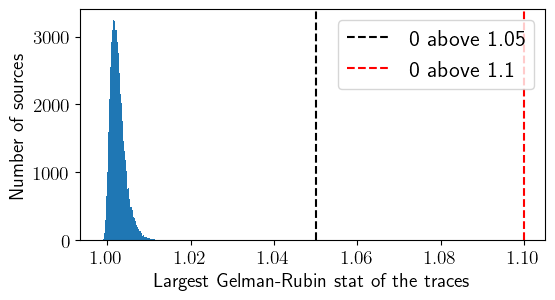

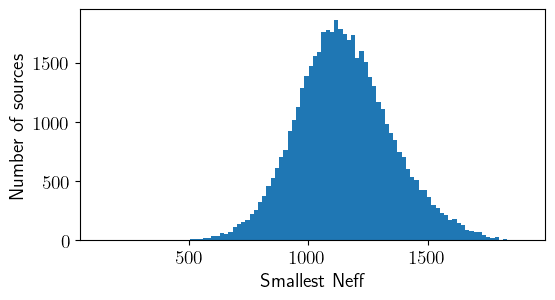

In [3]:
fig, ax = plt.subplots(figsize=(6, 3))
max_rhats = df_summary_red['r_hats_max'].to_numpy()
ax.hist(max_rhats, bins=100);
ax.set_xlabel('Largest Gelman-Rubin stat of the traces')
ax.set_ylabel('Number of sources')
for b,c in zip([1.05, 1.1], ['k', 'r']):
    ax.axvline(b, ls='--', c=c, label=f'{len(max_rhats[max_rhats>b])} above {b}')
ax.legend()

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(df_summary_red['n_effs_min'].to_numpy(), bins=100);
ax.set_xlabel('Smallest Neff')
ax.set_ylabel('Number of sources');

### Periodic (`cos`) kernel

In [4]:
%%time
df_summary_cos = pl.scan_parquet('../results/mcmc/cos/*.parquet').drop('log_posterior').with_columns(
    pl.max_horizontal('^r_hat_.*$').alias('r_hats_max'),
    pl.min_horizontal('^n_eff_.*$').alias('n_effs_min'),
    pl.col(pl.Array(pl.Float64, 2000)).arr.sum()/2000,
    pl.col(pl.Array(pl.Float64, 2000)).arr.std().name.suffix('_std'),
).drop('^r_hat_.*$').collect()

CPU times: user 10.3 s, sys: 223 ms, total: 10.5 s
Wall time: 1.58 s


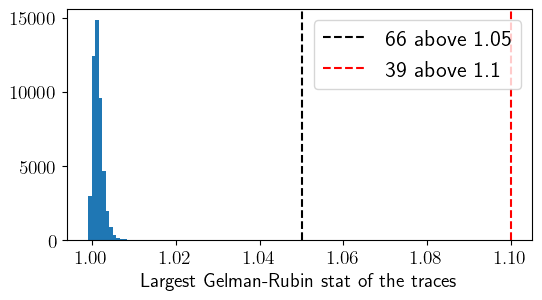

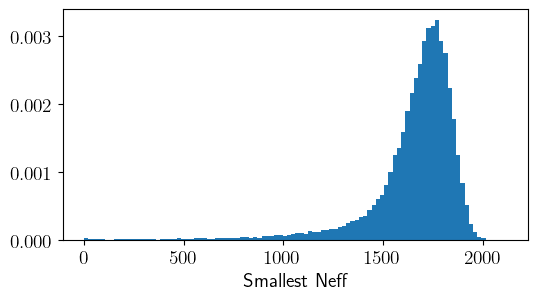

In [5]:
fig, ax = plt.subplots(figsize=(6, 3))
max_rhats = df_summary_cos['r_hats_max'].to_numpy()
limits = np.percentile(max_rhats, (0.1, 99.9))
ax.hist(max_rhats, bins=100, range=(limits[0], limits[1]));
ax.set_xlabel('Largest Gelman-Rubin stat of the traces')
for b,c in zip([1.05, 1.1], ['k', 'r']):
    ax.axvline(b, ls='--', c=c, label=f'{len(max_rhats[max_rhats>b])} above {b}')
ax.legend()

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(df_summary_cos['n_effs_min'].to_numpy(), bins=100, density=True);
ax.set_xlabel('Smallest Neff');

We will remove sources for why any of the MCMC posteriors did not converge:

In [6]:
len(df_summary_cos.filter(pl.col('r_hats_max')>1.05)), len(df_summary_red.filter(pl.col('r_hats_max')>1.05))

(66, 0)

In [7]:
df_goodrhat = pl.concat([
    df_summary_cos.sort('sourceid').select('sourceid', 'r_hats_max'),
    df_summary_red.sort('sourceid').select('r_hats_max').rename(lambda x: x+'_red')
], how = 'horizontal').filter((pl.col('r_hats_max') < 1.05) & (pl.col('r_hats_max_red') < 1.05))
df_goodrhat.shape
df_goodrhat.write_parquet('../results/good_rhat.parquet')

## Bayes factor estimations

Loading evidences for the *Gaia* QSOs

In [8]:
%%time

df_goodrhat = pl.read_parquet('../results/good_rhat.parquet')

df_nles = {
    model: pl.read_parquet( f"../results/mcmc/{model}/nle/*.parquet").with_columns(
        pl.col('ln_inv_ev').cast(pl.Float64),
        pl.col('ln_inv_ev_var').cast(pl.Float64)
    ) for model in ['red', 'cos', 'cos_times_red']
}

CPU times: user 30 ms, sys: 2.61 ms, total: 32.6 ms
Wall time: 12.2 ms


Log Bayes factors are computed following []().

In [9]:
def ln_bayes_factor_expr(model1, model2):
    ln_evidence_inv1, ln_evidence_inv_var1 = pl.col('ln_inv_ev'+model1), pl.col('ln_inv_ev_var'+model1)
    ln_evidence_inv2 = pl.col('ln_inv_ev'+model2)
    evidence_inv_ev1 = (ln_evidence_inv1).exp()
    evidence_inv_var_ev1 = (ln_evidence_inv_var1).exp()
    common_factor = 1.0 + evidence_inv_var_ev1 / (evidence_inv_ev1**2)
    ln_bf12 = ln_evidence_inv2 - ln_evidence_inv1 + (common_factor).log()
    return ln_bf12/np.log(10)

def ln_bayes_factor_std_expr(model1, model2):
    ln_evidence_inv1, ln_evidence_inv_var1 = pl.col('ln_inv_ev'+model1), pl.col('ln_inv_ev_var'+model1)
    ln_evidence_inv2, ln_evidence_inv_var2 = pl.col('ln_inv_ev'+model2), pl.col('ln_inv_ev_var'+model2)
    evidence_inv_ev1 = (ln_evidence_inv1).exp()
    evidence_inv_var_ev1 = (ln_evidence_inv_var1).exp()
    evidence_inv_ev2 = (ln_evidence_inv2).exp()
    evidence_inv_var_ev2 = (ln_evidence_inv_var2).exp()
    factor = evidence_inv_ev1**2 * evidence_inv_var_ev2 + evidence_inv_ev2**2 * evidence_inv_var_ev1
    ln_bf12_std = 0.5 * factor.log() - 2.0 * ln_evidence_inv1
    return ln_bf12_std/np.log(10)
    
df_bf = pl.concat([
    df_nles['cos'].rename(lambda x: x+'P' if 'ln' in x else x),
    df_nles['red'].rename(lambda x: x+'R' if 'ln' in x else x),
    df_nles['cos_times_red'].rename(lambda x: x+'Q' if 'ln' in x else x),
], how='align').with_columns(
    ln_bayes_factor_expr("P", "R").alias('log_bf_PR'),
).join(df_goodrhat, on='sourceid')

df_bf.sort('log_bf_PR', descending=True).head(5)

sourceid,ln_inv_evP,ln_inv_ev_varP,ln_inv_evR,ln_inv_ev_varR,ln_inv_evQ,ln_inv_ev_varQ,log_bf_PR,r_hats_max,r_hats_max_red
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2860871050077003264,13.710723,19.76157,28.787489,39.61278,19.837603,30.763166,6.547961,0.99977,0.999445
2799965875494150272,20.501776,33.196069,33.873489,60.447788,25.001352,42.961813,5.807438,1.001742,1.005341
2858120862257789184,13.025301,16.150687,25.676319,40.365978,18.932178,26.935526,5.494289,1.001709,1.001296
1694224002518759808,30.492514,51.37686,43.07074,77.483699,35.061405,61.499839,5.462683,0.999591,1.001506
3135056230337287296,15.494309,18.319555,27.683535,45.304714,19.035679,28.896503,5.293715,0.999812,1.001836


Loading evidences for the simulated *DRW* time series

In [10]:
%%time

df_sims_nles = {
    model: pl.read_parquet(f"../results/mcmc_red/{model}/nle/*.parquet") for model in [
    'red', 'cos', 
]}

CPU times: user 118 ms, sys: 43.9 ms, total: 162 ms
Wall time: 34.6 ms


In [11]:
df_bf_sims = pl.concat([
    df_sims_nles['cos'].rename(lambda x: x+'P' if 'ln' in x else x).sort('sourceid'),
    df_sims_nles['red'].rename(lambda x: x+'R' if 'ln' in x else x).sort('sourceid').drop('sourceid'),
], how='horizontal').with_columns(
    ln_bayes_factor_expr("P", "R").alias('log_bf_PR'),
    ln_bayes_factor_std_expr("P", "R").alias('log_bf_PR_std'),
)

## Simulation-based threshold for the Bayes factors

The 1e-3 threshold yields 181 candidates:

In [12]:
bf = 'log_bf_PR'
th = {}
for alpha in [1e-1, 5e-2, 1e-2, 1e-3, 1e-4]:
    th[alpha] = df_bf_sims.select(bf).quantile(1-alpha).item()
    P_is_best = (pl.col('ln_inv_evQ') > pl.col('ln_inv_evP')) & (pl.col('ln_inv_evR') > pl.col('ln_inv_evP'))
    num = len(df_bf.filter(P_is_best).filter(pl.col(bf) > th[alpha]))
    print(alpha, th[alpha], num, 100*num/len(df_bf))

alpha = 1e-3

smbhb_candidates = df_bf.filter(
    (pl.col('log_bf_PR') > th[alpha]) & (pl.col('ln_inv_evQ') > pl.col('ln_inv_evP'))
)

0.1 -1.8280496875116712 2100 4.33830516878073
0.05 -0.5316422898127791 2100 4.33830516878073
0.01 1.3195630929906612 1476 3.0492087757715987
0.001 3.0423590266573464 181 0.3739205883568153
0.0001 5.144040452887557 5 0.0103292980209065


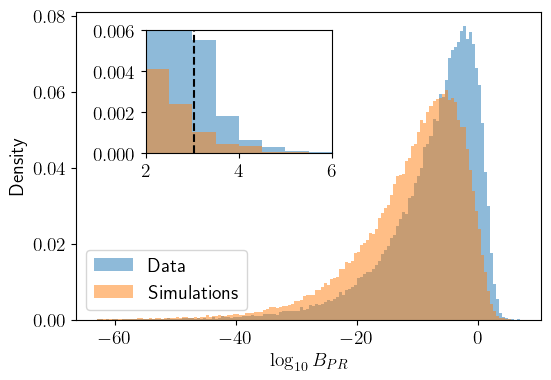

In [13]:
th = {}
density = True
bins = 140

rmax = np.round(df_bf.select(bf).max().item())
rmin = -63 
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(df_bf.select(bf), bins=bins, range=(rmin, rmax), alpha=0.5, density=density, label='Data');
ax.hist(df_bf_sims.select(bf), bins=bins, range=(rmin, rmax), alpha=0.5, density=density, label='Simulations');
ax.set_xlabel('log10 Bayes factor')
th[bf] = df_bf_sims.select(bf).quantile(1-1e-3).item()
ax.set_xlabel(r'$\log_{{{10}}} B_{PR}$')
if density:
    ax.set_ylabel('Density')
else:
    ax.set_ylabel('Number of sources')
axis = ax.inset_axes([0.15, 0.54, 0.4, 0.4], xlim=(2, 6), ylim=(0, 0.006))
axis.hist(df_bf.select(bf), bins=bins, range=(rmin, rmax), alpha=0.5, density=density, label='data');
axis.hist(df_bf_sims.select(bf), bins=bins, range=(rmin, rmax), alpha=0.5, density=density, label='simulations');
axis.axvline(th[bf], c='k', ls='--')
plt.legend(loc=3, fontsize=14)
plt.savefig('figures/log10BPRsims.pdf', dpi=300, bbox_inches='tight')

## Inspecting the candidates

In [14]:
%%time

def get_samples(path, row):
    samples = pl.scan_parquet(path).slice(row, 1).drop(
        ['sourceid', '^r_hat_.*$', '^n_eff_.*$', 'log_posterior']
    ).collect().to_dicts()[0]
    return {k: jnp.array(v) for k,v in samples.items()}

mcmc_index = {}
for kernel in ['cos', 'red']:
    mcmc_index[kernel] = {}
    for file in Path(f'../results/mcmc/{kernel}/').glob('*.parquet'):
        df = pl.scan_parquet(file, include_file_paths='path', row_index_name='index').select(['sourceid', 'path', 'index']).collect()
        mcmc_index[kernel] = mcmc_index[kernel] | {sid: (path, index) for sid, path, index in zip(df['sourceid'].to_list(), df['path'].to_list(), df['index'].to_list())}

rng_key, rng_key_predict = random.split(random.PRNGKey(0))

CPU times: user 209 ms, sys: 29.3 ms, total: 239 ms
Wall time: 235 ms


Three examples from the 181 candidates

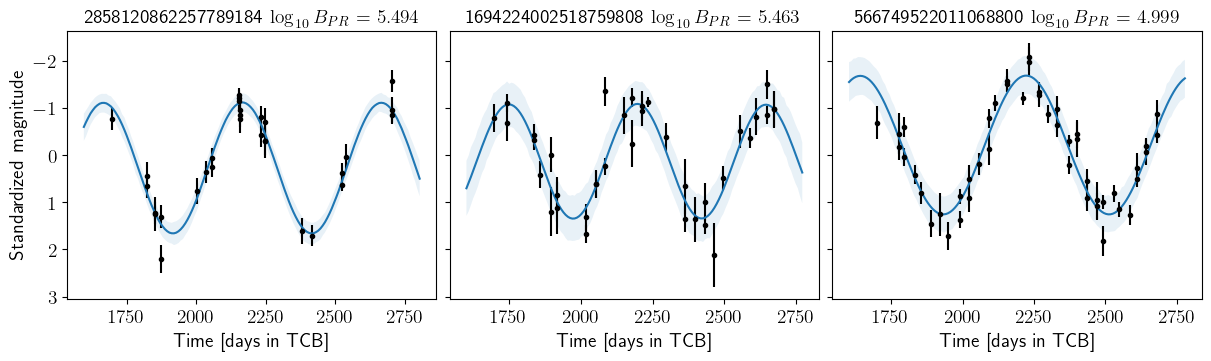

In [15]:
to_plot = smbhb_candidates.filter(
    pl.col('sourceid').is_in([2858120862257789184, 1694224002518759808, 566749522011068800])
).sort('log_bf_PR', descending=True)

def plot_source(sid, logBF, ax, sampling_key, kernels=['cos'], show_title=False):    
    time, mag, err, period = get_lc(sid)
    T = np.amax(time) - np.amin(time)
    time_pred = jnp.linspace(np.amin(time) - T/10, np.amax(time) + T/10, 150)
    ax.errorbar(time, mag, err, fmt='.', c='k')
    ax.invert_yaxis()
    for kernel in kernels:
        samples_ = get_samples(*mcmc_index[kernel][sid])
        post_means, predictions = predict_gp_parallel(
            jnp.asarray(time), jnp.asarray(mag), time_pred, 
            covariance_functions[kernel], samples_, sampling_key
        )
        percentiles = jnp.nanpercentile(predictions, jnp.array([5.0, 95.0]), axis=0)
        ax.plot(time_pred, jnp.nanmean(post_means, axis=0))
        ax.fill_between(time_pred, percentiles[0], percentiles[-1], alpha=0.1)
    logB = row['log_bf_PR']
    if show_title:
        ax.set_title(f'{sid}' + r' $\log_{10} B_{PR}$ = ' + f'${logB:0.3f}$')

fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True, constrained_layout=True)
axs[0].set_ylabel('Standardized magnitude')

for row, ax in zip(to_plot.iter_rows(named=True), axs):
    sid, logBF = row['sourceid'], row['log_bf_PR']
    plot_source(sid, logBF, ax, rng_key_predict, show_title=True)
    ax.set_xlabel('Time [days in TCB]')
    
plt.savefig('figures/candidate_examples.pdf', dpi=300, bbox_inches='tight');

The sources with highest bayes factor among the 181 candidates

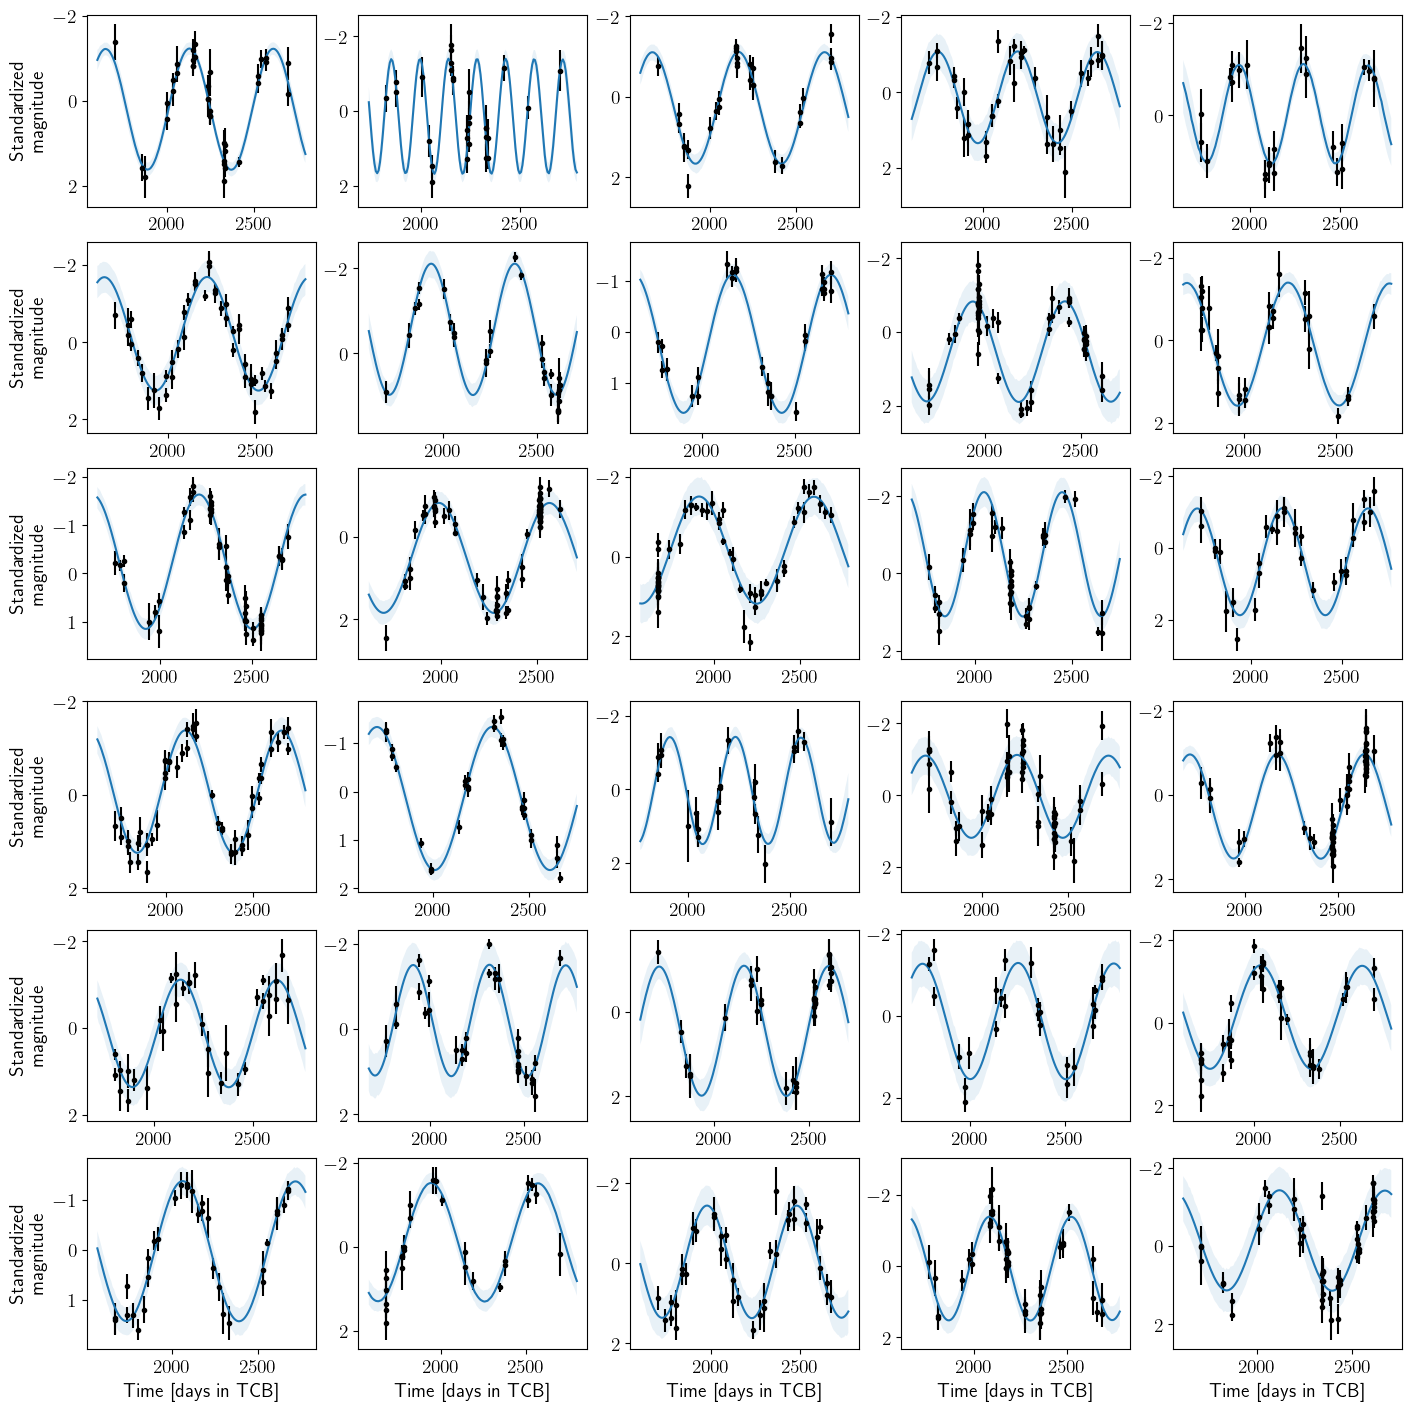

In [16]:
plot_cands = smbhb_candidates.sort('log_bf_PR', descending=True).head(30)
fig, axs = plt.subplots(6, 5, figsize=(14, 14), constrained_layout=True)

for ax, row in zip(axs.ravel(), plot_cands.iter_rows(named=True)):
    sid = row['sourceid']
    plot_source(sid, 0.0, ax, rng_key_predict)
    
for ax in axs[-1, :]:
    ax.set_xlabel('Time [days in TCB]')
for ax in axs[:, 0]:
    ax.set_ylabel('Standardized\nmagnitude')
plt.savefig('figures/candidates.pdf', dpi=300, bbox_inches='tight')

The sources with the highest Bayes factors among the 181 candidates that also have periods between T/2.5 and  T/1.5

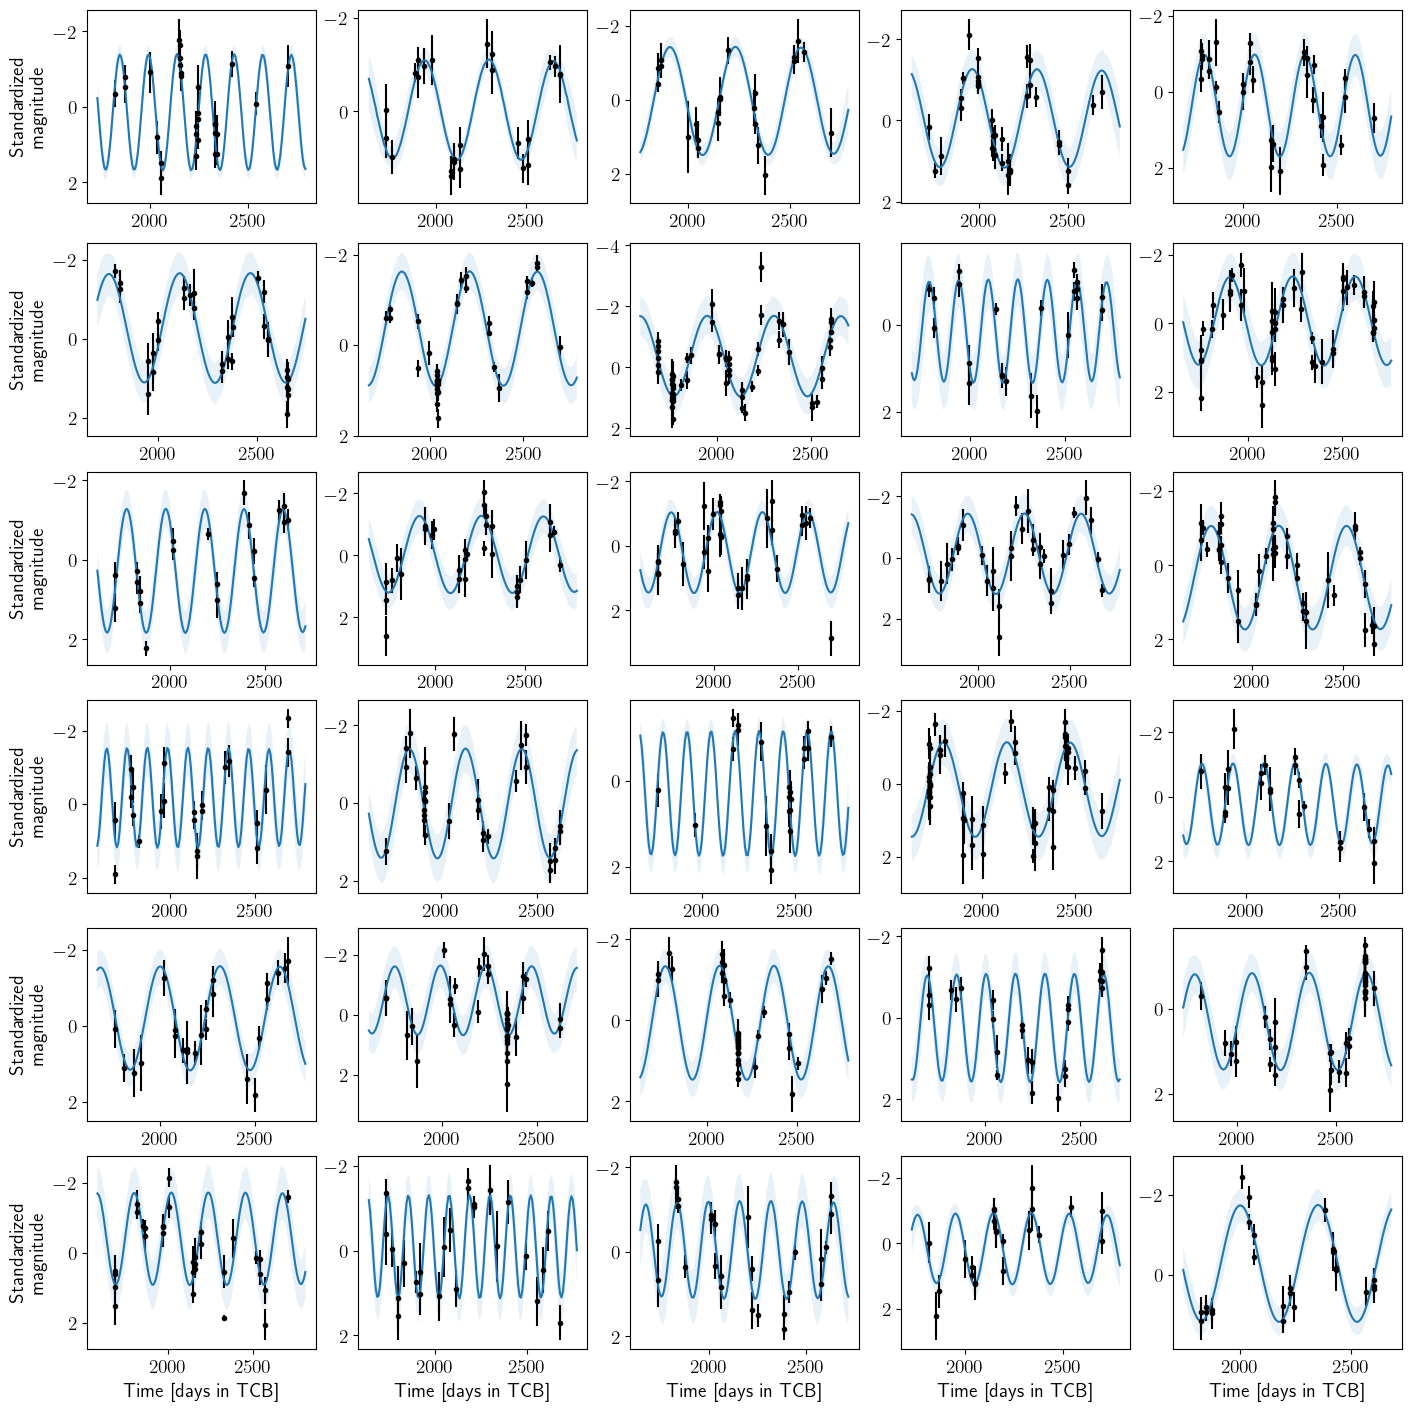

In [17]:
plot_cands = smbhb_candidates.join(
    df_summary_cos, on='sourceid'
).filter(1/pl.col('cos_frequency') < 933/2.5).sort('log_bf_PR', descending=True).head(30)
fig, axs = plt.subplots(6, 5, figsize=(14, 14), constrained_layout=True)

for ax, row in zip(axs.ravel(), plot_cands.iter_rows(named=True)):
    sid = row['sourceid']
    plot_source(sid, 0.0, ax, rng_key_predict)
for ax in axs[-1, :]:
    ax.set_xlabel('Time [days in TCB]')
for ax in axs[:, 0]:
    ax.set_ylabel('Standardized\nmagnitude')
plt.savefig('figures/candidates2.pdf', dpi=300, bbox_inches='tight')

## Catalog and light curve export

In [18]:
df_catalog = df_bf.drop(
    ['ln_inv_evP', 'ln_inv_ev_varP', 'ln_inv_evR', 'ln_inv_ev_varR', 'ln_inv_evQ', 'ln_inv_ev_varQ', 'r_hats_max', 'r_hats_max_red']
).sort('log_bf_PR', descending=True).join(
    df_summary_cos.with_columns(
        (1.0/pl.col('cos_frequency')).alias('period'),
        (pl.col('cos_frequency_std')/pl.col('cos_frequency')**2).alias('period_std')
    ).select(['sourceid', 'period', 'period_std']), on='sourceid'
)
df_catalog.write_csv('../results/bayes_factors.csv')

In [19]:
candidates_sids = smbhb_candidates.select('sourceid').to_series().to_list()

df_lcs = []
for sid in candidates_sids:
    file, line = lc_index[sid]
    df_lcs.append(pl.scan_parquet(file).slice(line, 1).collect())
pl.concat(df_lcs).write_parquet('../data/gaia_smbhb_candidates_lc_compressed.parquet', compression_level=22)

## Appendix: Bayes factor of the 181 candidates with red noise spectra with different slopes

In [20]:
%%time

df_nles_red = {
    model: pl.read_parquet(f"../results/mcmc/{model}/nle/*.parquet").with_columns(
        pl.col('ln_inv_ev').cast(pl.Float64),
        pl.col('ln_inv_ev_var').cast(pl.Float64)
    ) for model in ['red_15', 'red_2']
}

df_bf_red = df_bf.join(
    pl.concat([
        df_nles_red['red_15'].rename(lambda x: x+'R15' if 'ln' in x else x),
        df_nles_red['red_2'].rename(lambda x: x+'R2' if 'ln' in x else x),
    ], how='align'), on='sourceid'
).with_columns(
    ln_bayes_factor_expr("P", "R15").alias('log_bf_PR15'),
    ln_bayes_factor_expr("P", "R2").alias('log_bf_PR2'),
)

CPU times: user 12.2 ms, sys: 5.93 ms, total: 18.1 ms
Wall time: 7.61 ms


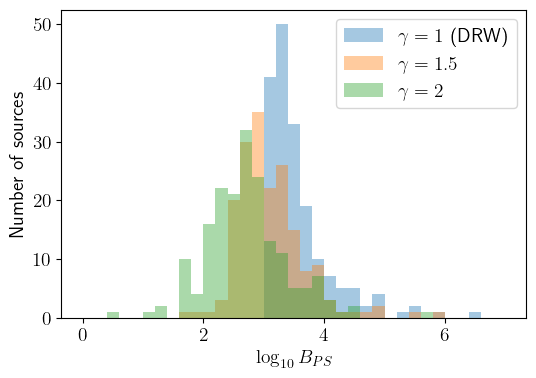

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(df_bf_red.select('log_bf_PR'), bins=35, range=(0, 7), alpha=0.4, label=r'$\gamma=1$ (DRW)')
ax.hist(df_bf_red.select('log_bf_PR15'), bins=35, range=(0, 7), alpha=0.4, label=r'$\gamma=1.5$')
ax.hist(df_bf_red.select('log_bf_PR2'), bins=35, range=(0, 7), alpha=0.4, label=r'$\gamma=2$')
ax.legend(fontsize=14)
ax.set_xlabel(r'$\log_{10} B_{PS}$')
ax.set_ylabel('Number of sources')
plt.savefig('figures/log10BPS.pdf', dpi=300, bbox_inches='tight')